In [8]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime 
import re
from matplotlib.font_manager import FontProperties      #自訂字型，顯示中文
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei'] 
plt.rcParams['axes.unicode_minus'] = False  
import matplotlib as mpl
# plt.style.use('ggplot')
mpl.rcParams['figure.figsize'] = (20,12)               #自訂圖片大小
mpl.rcParams.update({'font.size': 16})                 #自訂文字大小
from IPython.display import display                    #顯示每個欄位
pd.options.display.max_columns = None

import warnings
warnings.filterwarnings("ignore")

#lifetime套件
from lifetimes.plotting import *
from lifetimes.utils import *
from lifetimes import *

from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score
from sklearn.model_selection import cross_val_score
from matplotlib import pyplot as plt

### 整理建模資料

In [11]:
order_all_o = order_all.loc[order_all.order_date < '2019-04-01']

order_all_o.order_date = order_all_o.order_date.astype('datetime64')

order_all_o['joinperiod'] = order_all_o.order_date
old = order_all_o.groupby('member_id').agg({'order_date': lambda y: (order_all_o.order_date.max().date() - y.max().date()).days, 
                                          'osn'  : lambda y: len(y.unique()) , 
                                         'amount': lambda y: round(y.sum(),2),
                                        '小分類' : lambda y: len(y.unique()) ,                  
                                        '種類' : lambda y: len(y.unique()),
                                  'joinperiod': lambda y: (order_all_o.order_date.max().date() - y.min().date()).days}) 

old.columns = ['Recency','Frequency','Monetary','幾種類別','幾樣商品','joinperiod'] 

old = old.reset_index()

old.member_id = old.member_id.astype('object')

base = order_all_o[['member_id','order_date','amount']]

data = summary_data_from_transaction_data(base, 'member_id'
                                        , 'order_date',observation_period_end = '2019-03-31').reset_index()
data = data.drop('T',axis = 1)                                       

data.columns = ['member_id', 'Repo','Length']

old = pd.merge(data,old, on = 'member_id' , how = 'inner')

def cycle(a, b, c):
    if b == 0:
        return c
    else:
        return round(a/b,2)

old['cycle'] = old.apply(lambda x: cycle(x.Length ,x.Repo , x.Recency), axis = 1) 

# old['Avg_order'] =  round(old.Monetary / old.Frequency,2)
# old['Avg_qty'] =   round(old.Monetary / old.market_qty,2)

print(old.shape)
print(old.dtypes)
round(old.describe(),2)

(9508, 10)
member_id      object
Repo          float64
Length        float64
Recency         int64
Frequency       int64
Monetary        int64
幾種類別            int64
幾樣商品            int64
joinperiod      int64
cycle         float64
dtype: object


,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle
count,9508.00,9508.00,9508.00,9508.0,9508.00,9508.00,9508.00,9508.00,9508.00
mean,2.76,121.28,159.46,4.1,14962.34,2.26,2.68,280.74,129.97
std,5.14,152.55,146.41,6.5,28421.11,2.08,3.52,155.44,137.43
min,0.00,0.00,0.00,1.0,0.00,1.00,1.00,0.00,0.00
25%,0.00,0.00,18.00,1.0,3026.00,1.00,1.00,144.00,26.64
50%,1.00,20.00,113.00,2.0,6514.00,1.00,1.00,326.00,68.40
75%,3.00,247.25,280.00,5.0,16244.25,3.00,3.00,429.00,203.00
max,76.00,451.00,451.00,181.0,921973.00,22.00,72.00,451.00,451.00


In [12]:
now  = order_all.loc[order_all.order_date >= '2019-04-01'].member_id.value_counts().reset_index()
now.columns = ['member_id' , 'count']
old['target'] = old.member_id.isin(now.member_id) 

old.target = old.target.astype('int64')
old.target = old.target.astype('object')

print(old.target.value_counts())
print(old.shape)

old.head()

0    5554
1    3954
Name: target, dtype: int64
(9508, 11)


,member_id,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle,target
0,12,0.0,0.0,436,1,3033,1,1,436,436.00,0
1,70,1.0,9.0,85,2,7508,2,2,94,9.00,0
2,100,4.0,159.0,94,5,13925,2,2,253,39.75,1
3,111,0.0,0.0,430,1,5490,1,1,430,430.00,0
4,236,6.0,209.0,3,7,20983,5,6,212,34.83,1


In [13]:
X = old.copy()
X.head()

,member_id,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle,target
0,12,0.0,0.0,436,1,3033,1,1,436,436.00,0
1,70,1.0,9.0,85,2,7508,2,2,94,9.00,0
2,100,4.0,159.0,94,5,13925,2,2,253,39.75,1
3,111,0.0,0.0,430,1,5490,1,1,430,430.00,0
4,236,6.0,209.0,3,7,20983,5,6,212,34.83,1


In [14]:
Q = X[['Recency','cycle']]

quantile = Q.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
quantile = quantile.to_dict()

def Quant(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
X['Recency']=Q['Recency'].apply(Quant, args=('Recency',quantile))
X['cycle']=Q['cycle'].apply(Quant, args=('cycle',quantile))

Q1 = X.drop(['Recency','cycle','member_id','target'], axis=1)

quantile1 = Q1.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
quantile1 = quantile1.to_dict()

def Quant1(x,p,d):
      if x <= d[p][0.25]:
        return 1
      elif x <= d[p][0.50]:
        return 2
      elif x <= d[p][0.75]: 
        return 3
      else:
        return 4

    
X['Repo']=Q1['Repo'].apply(Quant1, args=('Repo',quantile1))
X['Length']=Q1['Length'].apply(Quant1, args=('Length',quantile1))
X['Frequency']=Q1['Frequency'].apply(Quant1, args=('Frequency',quantile1))
X['Monetary']=Q1['Monetary'].apply(Quant1, args=('Monetary',quantile1))
X['joinperiod']=Q1['joinperiod'].apply(Quant1, args=('joinperiod',quantile1))
X['幾種類別']=Q1['幾種類別'].apply(Quant1, args=('幾種類別',quantile1))
X['幾樣商品']=Q1['幾樣商品'].apply(Quant1, args=('幾樣商品',quantile1))

X.target = X.target.astype('int')
# X = X.drop(['Avg_order','Avg_qty','item'],axis = 1)
X.head()

,member_id,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle,target
0,12,1,1,1,1,2,1,1,4,1,0
1,70,2,2,3,2,3,3,3,1,4,0
2,100,4,3,3,3,3,3,3,2,3,1
3,111,1,1,1,1,2,1,1,4,1,0
4,236,4,3,4,4,4,4,4,2,3,1


In [15]:
X.target.value_counts()

0    5554
1    3954
Name: target, dtype: int64

In [16]:
# 類別數據不平衡 
#將target = 不買的人數 作抽樣  （另一種方法 再研究：SMOTE )
# X1 = X.loc[X.target == 1]
# X0 = X.loc[X.target == 0]

# X0 = X0.sample(n = 2500,random_state = None ,axis=0) 
# XX = pd.concat([X1, X0], ignore_index=True)

# print(XX.shape)
# XX.target.value_counts()

### 建立模型

In [17]:
train_X = X.drop(['member_id','target'] ,axis = 1)
estimator = LogisticRegression(penalty='l2', 
          dual=False, tol=0.0001, C= 0.001, fit_intercept=True, 
          intercept_scaling=1, class_weight=None, 
          random_state=None, solver='newton-cg', max_iter=30, 
          multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

cross_val_score(estimator, train_X, X.target, cv=5).mean()

0.7593612264098734

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X , X.target , test_size=0.3,random_state=121)

X_train1 = X_train.drop(['member_id','target'] ,axis = 1)
X_test1  = X_test.drop(['member_id','target'] ,axis = 1)
print (X_train1.shape, y_train.shape)
print (X_test1.shape, y_test.shape)

(6655, 9) (6655,)
(2853, 9) (2853,)


In [19]:
print(y_train.value_counts())
y_test.value_counts()

0    3882
1    2773
Name: target, dtype: int64


0    1672
1    1181
Name: target, dtype: int64

In [20]:
# 設定模型與模型參數
log_reg = LogisticRegression(penalty='l2', 
          dual=False, tol=0.0001, C= 0.001, fit_intercept=True, 
          intercept_scaling=1, class_weight=None, 
          random_state=None, solver='newton-cg', max_iter=30, 
          multi_class='ovr', verbose=0, warm_start=False, n_jobs=1)

# 使用 Train 資料訓練模型
log_reg.fit(X_train1 , y_train)

LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=30, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='newton-cg', tol=0.0001,
          verbose=0, warm_start=False)

In [21]:
# 印出截距
print(log_reg.intercept_ )

# 印出係數
print(log_reg.coef_)
X_train1.columns

[-3.3209565]
[[ 0.09978537  0.06729657  0.50657157  0.08281782  0.09237695  0.09300992
   0.08861216 -0.08328475  0.24537801]]


Index(['Repo', 'Length', 'Recency', 'Frequency', 'Monetary', '幾種類別', '幾樣商品',
       'joinperiod', 'cycle'],
      dtype='object')

In [22]:
abs(log_reg.coef_[0])

array([0.09978537, 0.06729657, 0.50657157, 0.08281782, 0.09237695,
       0.09300992, 0.08861216, 0.08328475, 0.24537801])

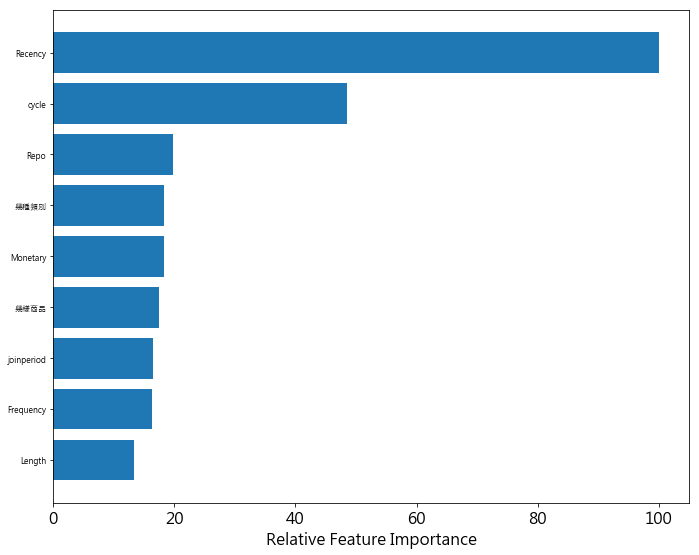

In [23]:
feature_importance = abs(log_reg.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

featfig = plt.figure(figsize=(10,8))
featax = featfig.add_subplot(1, 1, 1)
featax.barh(pos, feature_importance[sorted_idx], align='center')
featax.set_yticks(pos)
featax.set_yticklabels(np.array(X_train1.columns)[sorted_idx], fontsize=8)
featax.set_xlabel('Relative Feature Importance')

plt.tight_layout()   
plt.show()

In [24]:
log_reg.score(X_test1 , y_test)

0.753242201191728

In [25]:
#y_pred = log_reg.predict(X_test)
y_pred_pro = np.round(log_reg.predict_proba(X_test1),2)[:, 1]

threshold = 0.5
y_pred_binarized = np.where(y_pred_pro > threshold, 1, 0)

acc = accuracy_score(y_test, y_pred_binarized)
print("Accuracy: ", acc)

Accuracy:  0.755695758850333


In [26]:
#評估決策樹模型好壞
from sklearn.metrics import classification_report,confusion_matrix

print(classification_report( y_test , y_pred_binarized))
print(confusion_matrix( y_test , y_pred_binarized))

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      1672
           1       0.70      0.71      0.71      1181

   micro avg       0.76      0.76      0.76      2853
   macro avg       0.75      0.75      0.75      2853
weighted avg       0.76      0.76      0.76      2853

[[1323  349]
 [ 348  833]]


In [27]:
# 計算提交結果
submit = X_test[['member_id']]
submit['target'] = y_pred_pro
submit['y_test'] = y_test

print(submit.sort_values( 'target' ,ascending = False).head())
submit.loc[submit.target>0.53].shape

     member_id  target  y_test
8173    380830    0.84       1
7854    379599    0.84       1
7022    375340    0.83       1
4232    198127    0.83       1
3213    157235    0.83       1


(965, 3)

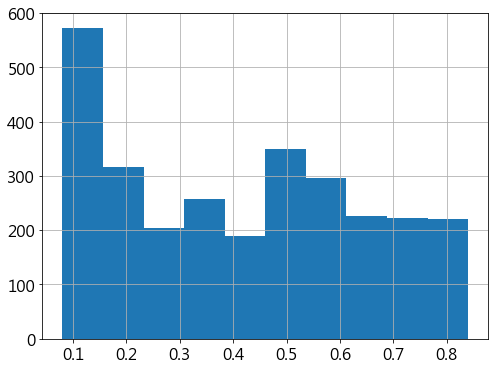

In [28]:
plt.figure(figsize=(8,6))
submit.target.hist()

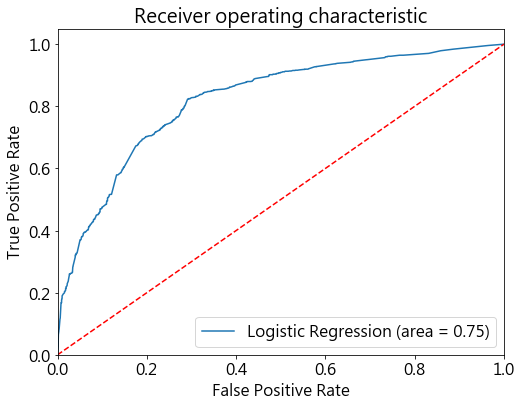

In [29]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
# plt.style.use('ggplot')
logit_roc_auc = roc_auc_score(y_test, log_reg.predict(X_test1))
fpr, tpr, thresholds = roc_curve(y_test, log_reg.predict_proba(X_test1)[:,1])
plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
#plt.savefig('Log_ROC')
plt.show()

### 用全部資料來作預測 看一個月會不會來買 （半年太長）

In [30]:
order_all_o1 = order_all.loc[order_all.order_date < '2019-10-01']

order_all_o1.order_date = order_all_o1.order_date.astype('datetime64')

order_all_o1['joinperiod'] = order_all_o1.order_date
old1 = order_all_o1.groupby('member_id').agg({'order_date': lambda y: (order_all_o1.order_date.max().date() - y.max().date()).days, 
                                          'osn'  : lambda y: len(y.unique()) , 
                                         'amount': lambda y: round(y.sum(),2),
                                        '小分類' : lambda y: len(y.unique()) ,                  
                                        '種類' : lambda y: len(y.unique()),
                                  'joinperiod': lambda y: (order_all_o1.order_date.max().date() - y.min().date()).days}) 

old1.columns = ['Recency','Frequency','Monetary','幾種類別','幾樣商品','joinperiod'] 

old1 = old1.reset_index()

old1.member_id = old1.member_id.astype('object')

base1 = order_all_o1[['member_id','order_date','amount']]

data1 = summary_data_from_transaction_data(base1, 'member_id'
                                        , 'order_date',observation_period_end = '2019-09-30').reset_index()
data1 = data1.drop('T',axis = 1)                                       

data1.columns = ['member_id', 'Repo','Length']

old1 = pd.merge(data1 , old1 , on = 'member_id' , how = 'inner')

def cycle1(a, b, c):
    if b == 0:
        return c
    else:
        return round(a/b,2)

old1['cycle'] = old1.apply(lambda x: cycle1(x.Length ,x.Repo , x.Recency), axis = 1) 

# old1['Avg_order'] =  round(old1.Monetary / old1.Frequency,2)
# old1['Avg_qty'] =   round(old1.Monetary / old1.market_qty,2)

print(old1.shape)
print(old1.dtypes)
round(old1.describe(),2)

(14437, 10)
member_id      object
Repo          float64
Length        float64
Recency         int64
Frequency       int64
Monetary        int64
幾種類別            int64
幾樣商品            int64
joinperiod      int64
cycle         float64
dtype: object


,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle
count,14437.00,14437.00,14437.00,14437.00,14437.00,14437.00,14437.00,14437.0,14437.00
mean,3.03,139.31,203.18,4.38,15382.98,2.37,2.94,342.5,153.43
std,5.83,188.25,191.75,7.24,31268.91,2.16,3.97,214.9,177.18
min,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.0,0.00
25%,0.00,0.00,46.00,1.00,3030.00,1.00,1.00,150.0,34.00
50%,1.00,42.00,132.00,2.00,6547.00,2.00,2.00,321.0,74.00
75%,4.00,204.00,325.00,5.00,16091.00,3.00,3.00,565.0,186.00
max,105.00,635.00,636.00,236.00,1228843.00,22.00,94.00,636.0,636.00


In [31]:
now1  = order_all.loc[order_all.order_date >= '2019-10-01'].member_id.value_counts().reset_index()
now1.columns = ['member_id' , 'count']
old1['target'] = old1.member_id.isin(now1.member_id) 

old1.target = old1.target.astype('int64')
old1.target = old1.target.astype('object')

print(old1.target.value_counts())
print(old1.shape) #,now.shape) 

0    11713
1     2724
Name: target, dtype: int64
(14437, 11)


In [32]:
K = old1.copy()

QQ = K[['Recency','cycle']]

quantilee = QQ.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
quantilee = quantilee.to_dict()

def Quantt(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
K['Recency']=QQ['Recency'].apply(Quantt, args=('Recency',quantilee))
K['cycle']=QQ['cycle'].apply(Quantt, args=('cycle',quantilee))

QQ1 = K.drop(['Recency','cycle','member_id','target'], axis=1)

quantilee1 = QQ1.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
quantilee1 = quantilee1.to_dict()

def Quantt1(x,p,d):
      if x <= d[p][0.25]:
        return 1
      elif x <= d[p][0.50]:
        return 2
      elif x <= d[p][0.75]: 
        return 3
      else:
        return 4

    
K['Repo']=QQ1['Repo'].apply(Quantt1, args=('Repo',quantilee1))
K['Length']=QQ1['Length'].apply(Quantt1, args=('Length',quantilee1))
K['Frequency']=QQ1['Frequency'].apply(Quantt1, args=('Frequency',quantilee1))
K['Monetary']=QQ1['Monetary'].apply(Quantt1, args=('Monetary',quantilee1))
K['幾種類別']=QQ1['幾種類別'].apply(Quantt1, args=('幾種類別',quantilee1))
K['幾樣商品']=QQ1['幾樣商品'].apply(Quantt1, args=('幾樣商品',quantilee1))
K['joinperiod']=QQ1['joinperiod'].apply(Quantt1, args=('joinperiod',quantilee1))


In [33]:
K1 = K.drop(['member_id','target'],axis =1)
log_reg_pred = np.round(log_reg.predict_proba(K1),4)[:, 1]

In [34]:
submit_all = K[['member_id']]
submit_all['target_pred'] = log_reg_pred
submit_all['actual'] = K[['target']]

print(submit_all.shape)
submit_all.dtypes

(14437, 3)


member_id       object
target_pred    float64
actual          object
dtype: object

In [35]:
submit_all = pd.DataFrame(submit_all)
# submit_all.sort_values( 'target_pred' ,ascending = False).head() 
submit_all.loc[(submit_all.target_pred > 0.6) & (submit_all.actual == 1)].head()

,member_id,target_pred,actual
4,100,0.6029,1
7,269,0.8224,1
9,296,0.6858,1
12,323,0.6111,1
15,358,0.6423,1


In [36]:
submit_all.actual = submit_all.actual.astype('int64')

#評估模型好壞
from sklearn.metrics import classification_report,confusion_matrix
from sklearn import  ensemble, preprocessing, metrics

threshold = 0.5
y_pred_binarized = np.where(submit_all.target_pred >= threshold, 1, 0)

print(classification_report( submit_all.actual , y_pred_binarized))
print(confusion_matrix( submit_all.actual , y_pred_binarized))

# 績效
print(metrics.accuracy_score( submit_all.actual , y_pred_binarized)) #不準

              precision    recall  f1-score   support

           0       0.93      0.69      0.79     11713
           1       0.36      0.76      0.49      2724

   micro avg       0.70      0.70      0.70     14437
   macro avg       0.64      0.72      0.64     14437
weighted avg       0.82      0.70      0.73     14437

[[8034 3679]
 [ 643 2081]]
0.7006303248597354


In [37]:
#直接算 
from sklearn.metrics import precision_score, recall_score, fbeta_score
precision = precision_score(submit_all.actual , y_pred_binarized) # 計算 Precision
recall = recall_score(submit_all.actual , y_pred_binarized) # 計算 Recall
print(precision , recall)

0.36128472222222224 0.7639500734214391


In [38]:
for i in range(50,75,5):
    print(i/100)
    pred = np.where(submit_all.target_pred >= i/100, 1, 0)
    print(pd.DataFrame(submit_all.loc[submit_all.target_pred >= i/100].actual.shape))
    print(pd.DataFrame(submit_all.loc[submit_all.target_pred >= i/100].actual.value_counts()))
    print(round(precision_score(submit_all.actual ,pred),4))
    print("\n")

0.5
      0
0  5760
   actual
0    3679
1    2081
0.3613


0.55
      0
0  4647
   actual
0    2761
1    1886
0.4059


0.6
      0
0  3734
   actual
0    2071
1    1663
0.4454


0.65
      0
0  2964
   actual
0    1505
1    1459
0.4922


0.7
      0
0  2093
   actual
1    1149
0     944
0.549




In [39]:
print(submit_all.sort_values(by = 'target_pred' , ascending = False).head(4000).shape)
submit_all.sort_values(by = 'target_pred' , ascending = False).head(4000).actual.value_counts()

(4000, 3)


0    2266
1    1734
Name: actual, dtype: int64

In [40]:
sample1 = K.sample(n = 4000 ,axis=0)

print(sample1.shape)

sample1.target.value_counts()

(4000, 11)


0    3251
1     749
Name: target, dtype: int64

In [41]:
#八月預測名單
aug_list = submit_all.sort_values(by = 'target_pred' , ascending = False).head(4000)

# aug_list.to_csv('./aug_list.csv',index=False)

In [42]:
aug_list

,member_id,target_pred,actual
13227,432974,0.8364,0
10863,417490,0.8364,1
12962,431940,0.8364,0
12689,424711,0.8364,0
13108,432527,0.8364,1
13058,432393,0.8364,1
12619,424431,0.8364,0
12693,424718,0.8364,0
13548,434142,0.8364,1
8887,383071,0.8364,1


### 最終 預測九月名單

In [44]:
sep = order_all.loc[order_all.order_date < '2019-11-01']

sep.order_date = sep.order_date.astype('datetime64')

sep['joinperiod'] = sep.order_date
sep1 = sep.groupby('member_id').agg({'order_date': lambda y: (sep.order_date.max().date() - y.max().date()).days, 
                                          'osn'  : lambda y: len(y.unique()) , 
                                         'amount': lambda y: round(y.sum(),2),
                                        '小分類' : lambda y: len(y.unique()) ,                  
                                        '種類' : lambda y: len(y.unique()),
                                  'joinperiod': lambda y: (sep.order_date.max().date() - y.min().date()).days}) 

sep1.columns = ['Recency','Frequency','Monetary','幾種類別','幾樣商品','joinperiod'] 

sep1 = sep1.reset_index()

sep1.member_id = sep1.member_id.astype('object')

sep2 = sep[['member_id','order_date','amount']]

sep3 = summary_data_from_transaction_data(sep2, 'member_id'
                                        , 'order_date',observation_period_end = '2019-10-31').reset_index()
sep3 = sep3.drop('T',axis = 1)                                       

sep3.columns = ['member_id', 'Repo','Length']

sep3 = pd.merge(sep3 , sep1 , on = 'member_id' , how = 'inner')

def cycle2(a, b, c):
    if b == 0:
        return c
    else:
        return round(a/b,2)

sep3['cycle'] = sep3.apply(lambda x: cycle2(x.Length ,x.Repo , x.Recency), axis = 1) 

# old1['Avg_order'] =  round(old1.Monetary / old1.Frequency,2)
# old1['Avg_qty'] =   round(old1.Monetary / old1.market_qty,2)

print(sep3.shape)
print(sep3.dtypes)
round(sep3.describe(),2)

(15273, 10)
member_id      object
Repo          float64
Length        float64
Recency         int64
Frequency       int64
Monetary        int64
幾種類別            int64
幾樣商品            int64
joinperiod      int64
cycle         float64
dtype: object


,Repo,Length,Recency,Frequency,Monetary,幾種類別,幾樣商品,joinperiod,cycle
count,15273.00,15273.00,15273.00,15273.00,15273.00,15273.00,15273.00,15273.00,15273.00
mean,3.12,147.41,206.45,4.47,15653.70,2.38,2.99,353.85,157.45
std,6.01,197.34,201.65,7.43,31869.75,2.16,4.04,224.33,184.04
min,0.00,0.00,0.00,1.00,0.00,1.00,1.00,0.00,0.00
25%,0.00,0.00,36.00,1.00,3031.00,1.00,1.00,163.00,34.37
50%,1.00,47.00,133.00,2.00,6602.00,2.00,2.00,321.00,74.50
75%,4.00,218.00,336.00,5.00,16283.00,3.00,3.00,590.00,196.00
max,109.00,667.00,667.00,243.00,1267720.00,22.00,97.00,667.00,667.00


In [45]:
P = sep3.copy()

P1 = P[['Recency','cycle']]

sep_quantile = P1.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
sep_quantile = sep_quantile.to_dict()

def sep_q(x,p,d):
    if x <= d[p][0.25]:
        return 4
    elif x <= d[p][0.50]:
        return 3
    elif x <= d[p][0.75]: 
        return 2
    else:
        return 1
    
P['Recency']=P1['Recency'].apply(sep_q, args=('Recency',sep_quantile))
P['cycle']=P1['cycle'].apply(sep_q, args=('cycle',sep_quantile))

P2 = P.drop(['Recency','cycle','member_id'], axis=1)

sep_quantile1 = P2.apply(lambda x : x.quantile(q=[0.25,0.5,0.75]))
sep_quantile1 = sep_quantile1.to_dict()

def sep_q1(x,p,d):
      if x <= d[p][0.25]:
        return 1
      elif x <= d[p][0.50]:
        return 2
      elif x <= d[p][0.75]: 
        return 3
      else:
        return 4

P['Repo'] = P2['Repo'].apply(sep_q1, args=('Repo',sep_quantile1))
P['Length'] = P2['Length'].apply(sep_q1, args=('Length',sep_quantile1))
P['Frequency'] = P2['Frequency'].apply(sep_q1, args=('Frequency',sep_quantile1))
P['Monetary'] = P2['Monetary'].apply(sep_q1, args=('Monetary',sep_quantile1))
P['幾種類別'] = P2['幾種類別'].apply(sep_q1, args=('幾種類別',sep_quantile1))
P['幾樣商品'] = P2['幾樣商品'].apply(sep_q1, args=('幾樣商品',sep_quantile1))
P['joinperiod'] = P2['joinperiod'].apply(sep_q1, args=('joinperiod',sep_quantile1))

In [46]:
P3 = P.drop(['member_id'],axis =1)
sep_log_reg_pred = np.round(log_reg.predict_proba(P3),4)[:, 1]  

sep_submit = P[['member_id']]
sep_submit['target_pred'] = sep_log_reg_pred

sep_submit.member_id.nunique()

15273

round(pd.merge(sep3 , submit_all_list, on = 'member_id' , how = 'inner').describe(),2)